# **_k_-means Demo**

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from IPython.display import clear_output
from sklearn.cluster import KMeans

# Data

We create a mixture of two bivariate Gaussian distributions:

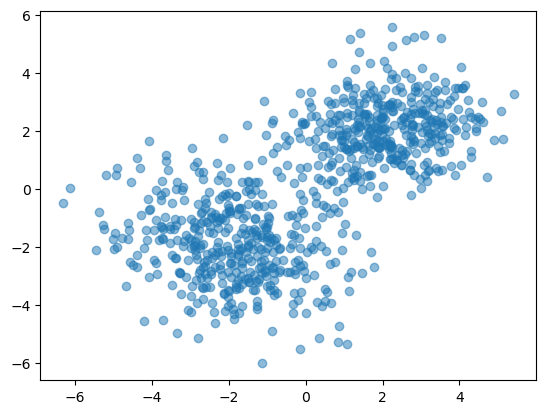

In [29]:
samples1 = np.random.multivariate_normal(
    mean=[2.0, 2.0], cov=[[1.5, 0.5], [0.5, 1.5]], size=400
)
samples2 = np.random.multivariate_normal(
    mean=[-2.0, -2.0], cov=[[2.0, -0.5], [-0.5, 2.0]], size=400
)
samples = np.concatenate((samples1, samples2))

plt.scatter(x=samples[:, 0], y=samples[:, 1], alpha=0.5)
plt.show()

# _k_-means from `scikit-learn`

We use the _k_-means implementation from `scikit-learn` to group our samples into two clusters:

In [30]:
kmeans = KMeans(n_clusters=2, init="random", n_init="auto", random_state=0).fit(
    X=samples
)

By inspecting the labels, we see that the algorithm classified most samples correctly:

In [31]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

We can also inspect the location of the cluster centers:

In [32]:
kmeans.cluster_centers_

array([[ 2.0745799 ,  2.09180042],
       [-1.91747794, -1.90947001]])

Also, we can predict the labels for new data:

In [33]:
new_samples = np.array([[5.0, 1.0], [-3.0, -5.0], [0.0, 4.5]])
kmeans.predict(X=new_samples)

array([0, 1, 0], dtype=int32)

Lastly, we visualize the data:

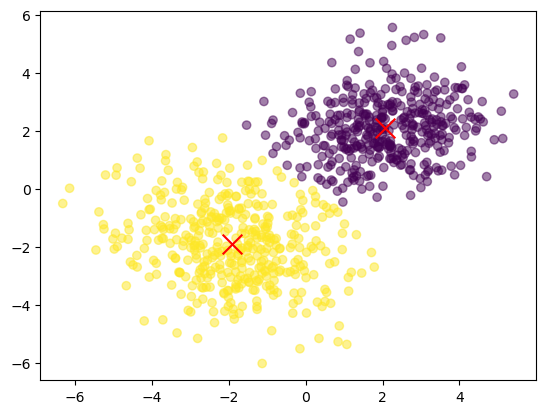

In [34]:
def kmeans_plot(
    samples: npt.ArrayLike,
    labels: npt.ArrayLike,
    centroids: npt.ArrayLike,
    title: str,
) -> None:
    plt.scatter(x=samples[:, 0], y=samples[:, 1], c=labels, alpha=0.5)
    plt.scatter(x=centroids[:, 0], y=centroids[:, 1], s=200, c="red", marker="x")
    plt.title(label=title)


kmeans_plot(
    samples=samples, labels=kmeans.labels_, centroids=kmeans.cluster_centers_, title=""
)

# _k_-means from scratch

## Initialization

The first step of the algorithm is to place $k$ initial cluster centers (centroids/means).
(Hence the name _k_-means.)
This can for example be done randomly; however, there are better and more sophisticated initialization methods.
Here we choose the Forgy method.
The Forgy method randomly chooses $k$ observations from the dataset and uses these as the initial means. 
The number of clusters $k$ has to be chosen manually (or as part of a hyperparameter optimization).

In [35]:
def kmeans_initialize(
    n_clusters: int, samples: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    # Generate n_clusters unique random indices
    unique_indices = np.random.choice(
        a=samples.shape[0], size=n_clusters, replace=False
    )

    # Select and return the centroids using the unique indices
    return samples[unique_indices]

In [36]:
centroids = kmeans_initialize(n_clusters=2, samples=samples)
print(centroids)

[[-4.94501207 -1.53024503]
 [ 5.08984486  2.67513502]]


## Assignment step

Assign each observation to the cluster with the nearest mean: that with the least Euclidean distance.

> Mathematically, this means partitioning the observations according to the Voronoi diagram generated by the means.

In [37]:
def kmeans_assignment_step(
    samples: npt.NDArray[np.float64], centroids: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    # Calculate the Euclidean distances between samples and centroids
    distances = np.linalg.norm(x=(samples[:, np.newaxis] - centroids), axis=2)

    # Find the index of the closest centroid for each sample
    labels = np.argmin(a=distances, axis=1)

    return labels

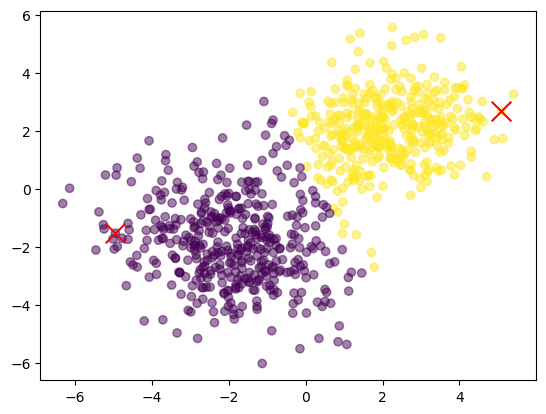

In [38]:
labels = kmeans_assignment_step(samples, centroids)
kmeans_plot(samples=samples, labels=labels, centroids=centroids, title="")

## Update step

Recalculate means (centroids) for observations assigned to each cluster.

In [39]:
def kmeans_update_step(
    samples: npt.NDArray[np.float64],
    labels: npt.NDArray[np.int64],
    centroids: npt.NDArray[np.float64],
) -> npt.NDArray[np.float64]:
    new_centroids = np.array(
        [samples[labels == cluster].mean(axis=0) for cluster in range(len(centroids))]
    )
    return new_centroids

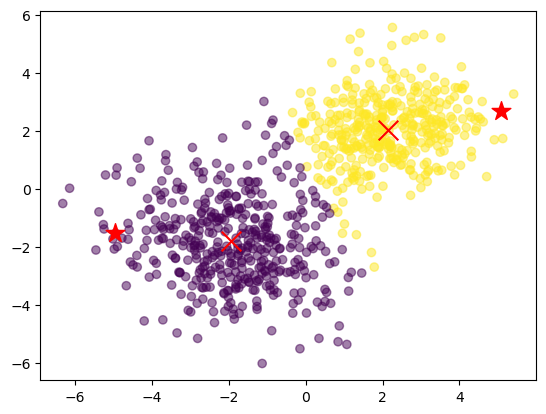

In [40]:
old_centroids = centroids
new_centroids = kmeans_update_step(samples=samples, labels=labels, centroids=centroids)
kmeans_plot(samples=samples, labels=labels, centroids=new_centroids, title="")
plt.scatter(x=old_centroids[:, 0], y=old_centroids[:, 1], s=200, c="red", marker="*")
plt.show()

## Iterate

Now we repeat these two steps until the centroids converge and do not move anymore.
Here we use a fixed number of iterations.

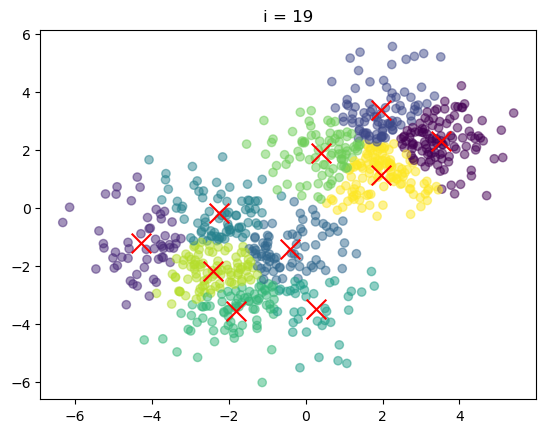

In [41]:
n_iterations = 20
n_clusters = 10

centroids = kmeans_initialize(n_clusters=n_clusters, samples=samples)

for i in range(n_iterations):
    labels = kmeans_assignment_step(samples=samples, centroids=centroids)
    centroids = kmeans_update_step(samples=samples, labels=labels, centroids=centroids)
    clear_output(wait=True)
    kmeans_plot(samples=samples, centroids=centroids, labels=labels, title=f"i = {i}")
    plt.pause(interval=0.2)